In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
from functools import partial
import pickle as pkl
from sklearn import metrics
from sklearn.linear_model import LinearRegression

import data
import config
import features
import train_reg
import neural_networks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
df = pd.read_pickle(oj(config.DIR_PROCESSED, 'df_full.pkl'))
df = features.normalize_track(df, track='X_same_length', by_time_point=False) # adds X_same_length_normalized
df = df[~df.short & ~df.hotspots] # filter out easy/invalid tracks

In [21]:
# each dataset has different number of cells each with different number of tracks
# the 'split' variable says whether a track is in the train or test set
df.groupby('dset')['split'].value_counts()

dset                    split
clath_aux+gak           train     2018
                        test       535
clath_aux+gak_a7d2      train     3327
                        test      1067
clath_aux+gak_a7d2_new  train     7877
                        test      1703
clath_aux+gak_new       train     3404
                        test       679
clath_aux_dynamin       train    34559
                        test      9367
clath_gak               train     3496
                        test      1498
Name: split, dtype: int64

# fit models

In [38]:
np.random.seed(42)
for dset_name in df['dset'].unique():
    d = df[(df['dset'] == dset_name) & (df['split'] == 'train')]
    checkpoint_fname = oj(config.DIR_MODELS, 'dnn_individual', f'dnn_{dset_name}.pkl')
    dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=0, arch='lstm', epochs=100)
    dnn.fit(X=d[['X_same_length_normalized']],
            y=d['Y_sig_mean_normalized'].values,
            verbose=False, checkpoint_fname=checkpoint_fname)
    pkl.dump({'model_state_dict': dnn.model.state_dict()}, open(checkpoint_fname, 'wb'))
    
    # fit dasc
    checkpoint_fname = oj(config.DIR_MODELS, 'dasc_individual', f'dasc_{dset_name}.pkl')
    dasc_model = LinearRegression().fit(d['X_d1'].values.reshape(-1, 1), d['Y_sig_mean_normalized'])
    pkl.dump(dasc_model, open(checkpoint_fname, 'wb'))

# look at model performance on corresponding test set

In [54]:
scores = {
    'r2': [],
    'acc': [],
    'r2_dasc': [],
    'acc_dasc': [],
}
dset_names = sorted(df['dset'].unique())
for dset_name in dset_names:
    # load models
    dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=0, arch='lstm')
    ckpt = pkl.load(open(oj(config.DIR_MODELS, 'dnn_individual', f'dnn_{dset_name}.pkl'), 'rb'))
    dnn.model.load_state_dict(ckpt['model_state_dict'])
    dasc_model = pkl.load(open(oj(config.DIR_MODELS, 'dasc_individual', f'dasc_{dset_name}.pkl'), 'rb'))
    
    # test on test set
    d = df[(df['dset'] == dset_name) & (df['split'] == 'test')]
    preds_reg = dnn.predict(d[['X_same_length_normalized']])
    preds_class = (preds_reg > 0).astype(int)
    preds_reg_dasc = dasc_model.predict(d['X_d1'].values.reshape(-1, 1))
    scores['r2'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_reg))
    scores['acc'].append(metrics.accuracy_score(d['y_consec_thresh'], preds_class))
    scores['r2_dasc'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_reg_dasc))
    scores['acc_dasc'].append(metrics.accuracy_score(d['y_consec_thresh'], (preds_reg_dasc > 0).astype(int)))    
scores = pd.DataFrame.from_dict(scores)
scores.index = dset_names
scores

,r2,acc,r2_dasc,acc_dasc
clath_aux+gak,0.382298,0.695327,0.230255,0.710280
clath_aux+gak_a7d2,0.287640,0.639175,0.160431,0.545455
clath_aux+gak_a7d2_new,0.449184,0.703464,0.049070,0.722842
clath_aux+gak_new,0.399651,0.486009,0.174010,0.387334
clath_aux_dynamin,0.428417,0.577346,0.232492,0.442084
clath_gak,0.265840,0.674232,0.121623,0.542056


# look at model performance on all test sets

In [56]:
dset_names = sorted(df['dset'].unique())
ks = []
for d in dset_names:
    ks += [f'r2_{d}', f'r2_dasc_{d}', f'acc_{d}', f'acc_dasc_{d}']
scores = {
    k: [] for k in ks
}
for dset_name in dset_names:
    # load models
    dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=0, arch='lstm')
    ckpt = pkl.load(open(oj(config.DIR_MODELS, 'dnn_individual', f'dnn_{dset_name}.pkl'), 'rb'))
    dnn.model.load_state_dict(ckpt['model_state_dict'])
    dasc_model = pkl.load(open(oj(config.DIR_MODELS, 'dasc_individual', f'dasc_{dset_name}.pkl'), 'rb'))
    
    # test on all test sets
    for test_set_name in dset_names:
        d = df[(df['dset'] == test_set_name) & (df['split'] == 'test')]
        preds_reg = dnn.predict(d[['X_same_length_normalized']])
        preds_class = (preds_reg > 0).astype(int)
        preds_reg_dasc = dasc_model.predict(d['X_d1'].values.reshape(-1, 1))
        scores[f'r2_{test_set_name}'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_reg))
        scores[f'acc_{test_set_name}'].append(metrics.accuracy_score(d['y_consec_thresh'], preds_class))
        scores[f'r2_dasc_{test_set_name}'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_reg_dasc))
        scores[f'acc_dasc_{test_set_name}'].append(metrics.accuracy_score(d['y_consec_thresh'], (preds_reg_dasc > 0).astype(int)))    
scores = pd.DataFrame.from_dict(scores)
scores.index = dset_names
scores

,r2_clath_aux+gak,r2_dasc_clath_aux+gak,acc_clath_aux+gak,acc_dasc_clath_aux+gak,r2_clath_aux+gak_a7d2,r2_dasc_clath_aux+gak_a7d2,acc_clath_aux+gak_a7d2,acc_dasc_clath_aux+gak_a7d2,r2_clath_aux+gak_a7d2_new,r2_dasc_clath_aux+gak_a7d2_new,...,acc_clath_aux+gak_new,acc_dasc_clath_aux+gak_new,r2_clath_aux_dynamin,r2_dasc_clath_aux_dynamin,acc_clath_aux_dynamin,acc_dasc_clath_aux_dynamin,r2_clath_gak,r2_dasc_clath_gak,acc_clath_gak,acc_dasc_clath_gak
clath_aux+gak,0.382298,0.230255,0.695327,0.710280,0.296460,0.122857,0.599813,0.573571,0.144187,-0.254820,...,0.537555,0.549337,0.222147,0.205760,0.727874,0.626988,0.257541,0.137569,0.700935,0.634179
clath_aux+gak_a7d2,0.383812,0.208478,0.738318,0.682243,0.287640,0.160431,0.639175,0.545455,0.174283,-0.162320,...,0.639175,0.477172,0.287534,0.192486,0.787339,0.575745,0.223136,0.167353,0.738318,0.615487
clath_aux+gak_a7d2_new,0.444630,0.266876,0.704673,0.600000,0.232815,0.049773,0.644799,0.481724,0.449184,0.049070,...,0.378498,0.384389,0.386302,0.230608,0.392228,0.431088,0.132996,0.047373,0.678238,0.568758
clath_aux+gak_new,0.410372,0.261727,0.687850,0.620561,0.274364,0.103577,0.591378,0.486410,0.377980,0.007082,...,0.486009,0.387334,0.359160,0.229621,0.682929,0.444112,0.205999,0.108741,0.694927,0.572764
clath_aux_dynamin,0.455501,0.266830,0.706542,0.613084,0.275750,0.085629,0.639175,0.485473,0.376100,0.022334,...,0.490427,0.385862,0.428417,0.232492,0.577346,0.442084,0.241851,0.088445,0.712951,0.570761
clath_gak,0.405169,0.161764,0.672897,0.570093,0.261604,0.116548,0.595127,0.457357,0.291007,-0.069745,...,0.415317,0.378498,0.365384,0.143822,0.600939,0.391587,0.265840,0.121623,0.674232,0.542056


In [57]:
s = scores[[k for k in scores if 'r2_c' in k]]

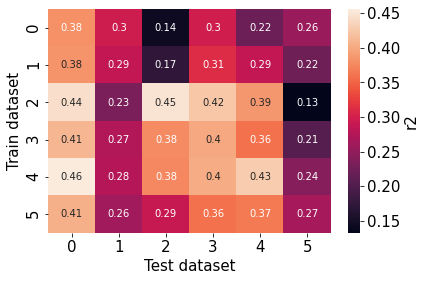

In [68]:
sns.heatmap(s, xticklabels=range(6),
            yticklabels=range(6), cbar_kws={'label': 'r2'},
            annot=True)
plt.xlabel('Test dataset')
plt.ylabel('Train dataset')

plt.show()

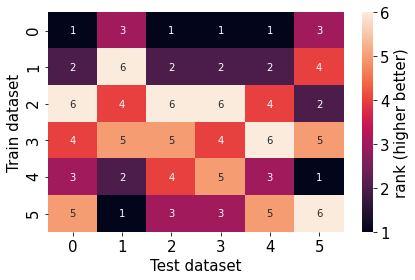

In [76]:
# we might expect that each model does better when tested on set corresponding to its training set
# in this case, we might expect it to outperform all other models on that set
# we see a small trend supporting this (e.g. model 1 an model 5), but it is not overwhelming

sns.heatmap(1 + np.argsort(s.values, axis=0), xticklabels=range(6),
            yticklabels=range(6), cbar_kws={'label': 'rank (higher better)'},
            annot=True)
plt.xlabel('Test dataset')
plt.ylabel('Train dataset')
plt.show()